### 0. Datensatz erstellen

In [1]:
!rm -rf densenet_onnx/dataset
!mkdir densenet_onnx/dataset
!cd densenet_onnx/dataset; touch .gitkeep; cd -

/home/jovyan/work/edge-benchmarking-client/examples


In [2]:
import shutil
from pathlib import Path

base_dataset_paths = [
    Path("densenet_onnx/base_dataset/car.jpg"),
    Path("densenet_onnx/base_dataset/mug.jpg"),
    Path("densenet_onnx/base_dataset/vulture.jpeg")
]

for i in range(100):
    for base_image_path in base_dataset_paths:
        dst_image_path = Path("densenet_onnx/dataset", f"{i}_{base_image_path.name}")
        shutil.copy2(base_image_path, dst_image_path)

### 1. Client erstellen

In [3]:
import os
from dotenv import load_dotenv
from edge_benchmarking_client.client import EdgeBenchmarkingClient

In [4]:
load_dotenv()

# Connection information
EDGE_FARM_API_PROTOCOL = "https"
EDGE_FARM_API_HOST = "api.edge-farm.agrifood-tef.edvsz.hs-osnabrueck.de"

# Basic API authentication
EDGE_FARM_API_BASIC_AUTH_USERNAME = os.getenv("EDGE_FARM_API_BASIC_AUTH_USERNAME")
EDGE_FARM_API_BASIC_AUTH_PASSWORD = os.getenv("EDGE_FARM_API_BASIC_AUTH_PASSWORD")

# Create the client
client = EdgeBenchmarkingClient(
    protocol=EDGE_FARM_API_PROTOCOL,
    host=EDGE_FARM_API_HOST,
    username=EDGE_FARM_API_BASIC_AUTH_USERNAME,
    password=EDGE_FARM_API_BASIC_AUTH_PASSWORD,
)

2024-07-12 21:45:21.198 INFO client - __init__: Created Edge Benchmarking client for user 'admin' and Edge Farm at 'https://api.edge-farm.agrifood-tef.edvsz.hs-osnabrueck.de'.
2024-07-12 21:45:21.245 INFO client - _test_connection: Edge Farm API is reachable with status code 200.


### 2. Benchmark-Daten finden und einlesen

In [5]:
!rm -rf densenet_onnx/dataset/.ipynb_checkpoints
!rm -rf densenet_onnx/base_dataset/.ipynb_checkpoints
!rm -rf densenet_onnx/model/.ipynb_checkpoints

In [6]:
EXAMPLE_ROOT_DIR = "densenet_onnx"
DATASET_DIR = f"{EXAMPLE_ROOT_DIR}/dataset"
MODEL_DIR= f"{EXAMPLE_ROOT_DIR}/model"

dataset = client.find_dataset(
    root_dir=DATASET_DIR, file_extensions={".jpg", ".jpeg"}
)
model = client.find_model(root_dir=MODEL_DIR)
model_metadata = client.find_model_metadata(root_dir=MODEL_DIR)
labels = client.find_labels(root_dir=MODEL_DIR)

2024-07-12 21:45:24.260 INFO client - find_dataset: Found dataset containing 300 samples with type(s) {'.jpg', '.jpeg'} in '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/dataset'.
2024-07-12 21:45:24.262 INFO client - _find_file: Found file '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model/densenet_onnx.onnx' with extension {'.onnx', '.pth', '.pt'} in '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model'.
2024-07-12 21:45:24.268 INFO client - _find_file: Found file '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model/config.pbtxt' with extension {'.pbtxt'} in '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model'.
2024-07-12 21:45:24.270 INFO client - _find_file: Found file '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model/densenet_labels.txt' with extension {'.txt'} in '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model'.


### 3. Benchmark-Job starten und auf Ergebnisse warten

In [7]:
from edge_benchmarking_types.edge_farm.models import TritonInferenceClientConfig

EDGE_DEVICE_HOST="edge-03"

inference_client_config = TritonInferenceClientConfig(
    host=EDGE_DEVICE_HOST,
    model_name=EXAMPLE_ROOT_DIR,
    num_classes=10,
    scaling="inception",
)

benchmark_job = client.benchmark(
    edge_device=EDGE_DEVICE_HOST,
    dataset=dataset,
    model=model,
    model_metadata=model_metadata,
    labels=labels,
    inference_client_config=inference_client_config,
)

2024-07-12 21:45:49.908 INFO client - upload_benchmark_data: 200 - {'bucket_name': 'a9369732-125d-45f8-aa5b-fc02a7e63124', 'dataset': ['dataset/39_car.jpg', 'dataset/90_mug.jpg', 'dataset/13_mug.jpg', 'dataset/91_mug.jpg', 'dataset/44_car.jpg', 'dataset/5_car.jpg', 'dataset/73_mug.jpg', 'dataset/1_car.jpg', 'dataset/60_car.jpg', 'dataset/43_car.jpg', 'dataset/10_mug.jpg', 'dataset/96_mug.jpg', 'dataset/31_car.jpg', 'dataset/9_mug.jpg', 'dataset/57_car.jpg', 'dataset/46_car.jpg', 'dataset/98_mug.jpg', 'dataset/5_mug.jpg', 'dataset/21_mug.jpg', 'dataset/83_mug.jpg', 'dataset/78_mug.jpg', 'dataset/13_car.jpg', 'dataset/50_mug.jpg', 'dataset/80_mug.jpg', 'dataset/2_car.jpg', 'dataset/70_car.jpg', 'dataset/29_car.jpg', 'dataset/53_mug.jpg', 'dataset/14_mug.jpg', 'dataset/82_car.jpg', 'dataset/45_car.jpg', 'dataset/71_mug.jpg', 'dataset/32_mug.jpg', 'dataset/45_mug.jpg', 'dataset/15_mug.jpg', 'dataset/72_mug.jpg', 'dataset/68_car.jpg', 'dataset/77_car.jpg', 'dataset/8_car.jpg', 'dataset/37_c

### 4. Ergebnisse abrufen

In [8]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F

from collections import defaultdict

2024-07-12 21:46:28.786 INFO utils - _init_num_threads: NumExpr defaulting to 4 threads.


In [9]:
benchmark_results = pd.DataFrame(benchmark_job.benchmark_results)
benchmark_results["time"] = pd.to_datetime(benchmark_results["time"])
benchmark_results.set_index("time", inplace=True)
print(benchmark_results)

In [11]:
final_inference_results = defaultdict(list)
for inference_respone_id, inference_result in benchmark_job.inference_results.items():
    predictions = np.stack(inference_result)

    logits = predictions[:, 0].astype(float)
    probabilities = F.softmax(torch.tensor(logits), dim=0)

    predicted_classes = predictions[:, -1]
    predicted_class_index = probabilities.argmax()
    predicted_probability = probabilities.max()
    predicted_class = predicted_classes[predicted_class_index]

    final_inference_results["response id"].append(inference_respone_id)
    final_inference_results["class"].append(predicted_class)
    final_inference_results["probability"].append(
        predicted_probability.item() * 100
    )

    inference_results_df = pd.DataFrame(final_inference_results)
print(inference_results_df)

             response id       class  probability
0            0_0_car.jpg  SPORTS CAR    64.780357
1            1_0_mug.jpg  COFFEE MUG    83.957105
2       2_0_vulture.jpeg     VULTURE    99.069883
3           3_10_car.jpg  SPORTS CAR    64.780357
4           4_10_mug.jpg  COFFEE MUG    83.957105
..                   ...         ...          ...
295       295_99_mug.jpg  COFFEE MUG    83.957105
296  296_99_vulture.jpeg     VULTURE    99.069883
297        297_9_car.jpg  SPORTS CAR    64.780357
298        298_9_mug.jpg  COFFEE MUG    83.957105
299   299_9_vulture.jpeg     VULTURE    99.069883

[300 rows x 3 columns]


### 5. Ergebnisse visualisieren

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Text(0, 0.5, 'Utilization [%]')

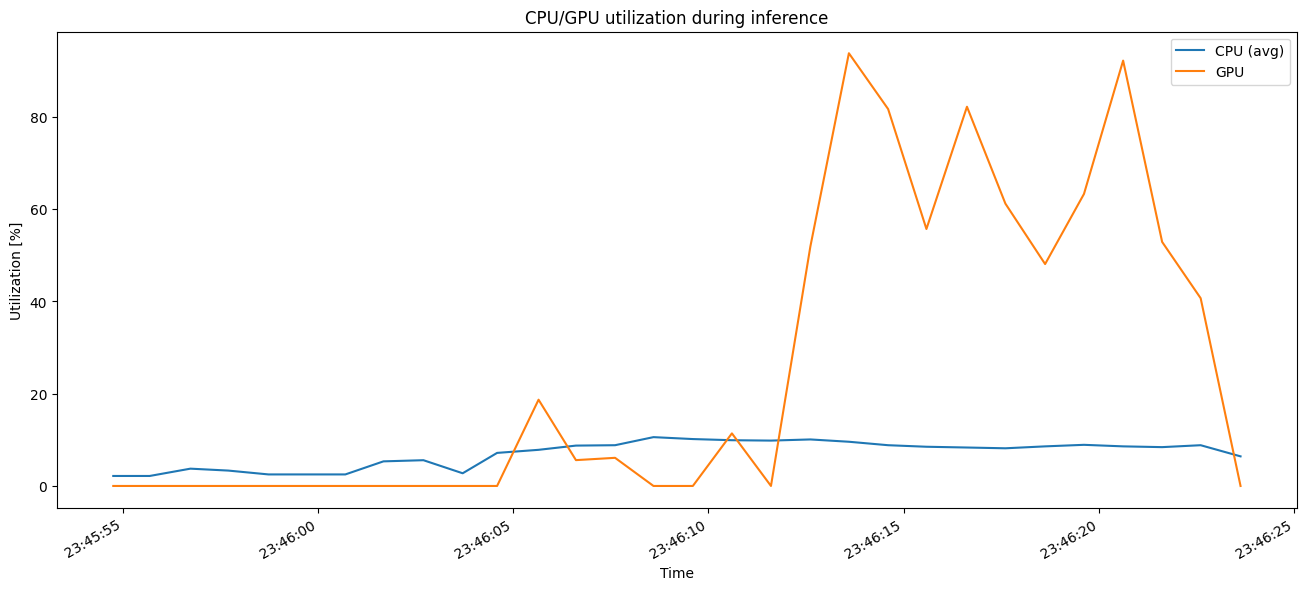

In [13]:
benchmark_results['CPU (avg)'] = benchmark_results[[f'CPU{i+1}' for i in range(12)]].mean(axis=1)

ax = benchmark_results.plot(y=["CPU (avg)", "GPU"], figsize=(16, 7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.title('CPU/GPU utilization during inference')
plt.xlabel('Time')
plt.ylabel('Utilization [%]')